In [1]:
B_HIGH_FILENAME = "B_high.txt"
B_LOW_FILENAME = "B_low.txt"

MAIN_RESULTS_FILENAME = "COMSOL Main Results.txt"

MAGNETIC_PROFILE_FILENAME = "COMSOL Magnetic Profile.txt"

COMSOL_PARAMETER_FILENAME = "params.txt"

In [2]:
import numpy as np

Load the high and low field data:

In [63]:
B_h = np.loadtxt(B_HIGH_FILENAME,skiprows=9)

In [64]:
B_l = np.loadtxt(B_LOW_FILENAME,skiprows=9)

Join the above data to build up the first quadrant of the air gap

In [7]:
B_1q = np.concatenate((B_h,B_l),axis=0)

In [8]:
B_1q

array([[  3.70795097e-02,   3.35426589e-02,   6.79921079e-01],
       [  3.88101783e-02,   3.15241187e-02,   8.02806723e-01],
       [  3.95096690e-02,   3.37468663e-02,   6.47266282e-01],
       [  3.53553391e-02,   3.53553391e-02,   5.82056154e-01],
       [  3.78867932e-02,   3.51989470e-02,   5.09235881e-01],
       [  3.72110937e-02,   3.72110937e-02,   3.29931839e-01],
       [  4.04312050e-02,   2.94162823e-02,   9.44589476e-01],
       [  4.11858051e-02,   3.17140143e-02,   8.09658077e-01],
       [  3.94954360e-02,   3.94954360e-02,   3.52431996e-01],
       [  4.00845782e-02,   3.65050147e-02,   4.88238265e-01],
       [  4.19378820e-02,   2.72252467e-02,   1.10720379e+00],
       [  4.27871945e-02,   2.96220759e-02,   9.65614170e-01],
       [  4.33012702e-02,   2.50000000e-02,   1.47531505e+00],
       [  4.42803124e-02,   2.74620630e-02,   1.12856273e+00],
       [  4.20163770e-02,   4.20163770e-02,   4.05626740e-01],
       [  4.26802772e-02,   3.89354104e-02,   5.1067600

Calculate a vector of angular values for the first quadrant

In [9]:
import teslamax

In [97]:
case_series = teslamax.get_comsol_parameters_series()


n_phi_points = 100

R_g = case_series['R_g']
R_i = case_series['R_i']
R_s = case_series['R_s']
R_o = case_series['R_o']


# create ranges for phi and r
phi_min = 0.0
phi_max = np.pi/2
    
phi_vector = np.linspace(phi_min,phi_max,n_phi_points)

# slightly offset the boundaries to avoid numerical problems at the interfaces
t_c = 5e-3
r_min = R_o +t_c
r_max = R_g -t_c
n_r_points = 5

r_vector = np.linspace(r_min,r_max,n_r_points)

In [98]:
phi_vector

array([ 0.        ,  0.01586663,  0.03173326,  0.04759989,  0.06346652,
        0.07933315,  0.09519978,  0.11106641,  0.12693304,  0.14279967,
        0.1586663 ,  0.17453293,  0.19039955,  0.20626618,  0.22213281,
        0.23799944,  0.25386607,  0.2697327 ,  0.28559933,  0.30146596,
        0.31733259,  0.33319922,  0.34906585,  0.36493248,  0.38079911,
        0.39666574,  0.41253237,  0.428399  ,  0.44426563,  0.46013226,
        0.47599889,  0.49186552,  0.50773215,  0.52359878,  0.53946541,
        0.55533203,  0.57119866,  0.58706529,  0.60293192,  0.61879855,
        0.63466518,  0.65053181,  0.66639844,  0.68226507,  0.6981317 ,
        0.71399833,  0.72986496,  0.74573159,  0.76159822,  0.77746485,
        0.79333148,  0.80919811,  0.82506474,  0.84093137,  0.856798  ,
        0.87266463,  0.88853126,  0.90439789,  0.92026451,  0.93613114,
        0.95199777,  0.9678644 ,  0.98373103,  0.99959766,  1.01546429,
        1.03133092,  1.04719755,  1.06306418,  1.07893081,  1.09

In [99]:
r_vector

array([ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ])

Calculate a matrix of $(r,\phi)$ points  along the first quadrant where to evaluate the field (in this controlled grid), and interpolate from the previous array (where each row corresponde to a radial chord i.e. a single value of $\phi$)

In [100]:
r_grid, phi_grid = np.meshgrid(r_vector,phi_vector)

In [101]:
r_grid

array([[ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0.06  ,  0.0625,  0.065 ],
       [ 0.055 ,  0.0575,  0

In [102]:
phi_grid

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01586663,  0.01586663,  0.01586663,  0.01586663,  0.01586663],
       [ 0.03173326,  0.03173326,  0.03173326,  0.03173326,  0.03173326],
       [ 0.04759989,  0.04759989,  0.04759989,  0.04759989,  0.04759989],
       [ 0.06346652,  0.06346652,  0.06346652,  0.06346652,  0.06346652],
       [ 0.07933315,  0.07933315,  0.07933315,  0.07933315,  0.07933315],
       [ 0.09519978,  0.09519978,  0.09519978,  0.09519978,  0.09519978],
       [ 0.11106641,  0.11106641,  0.11106641,  0.11106641,  0.11106641],
       [ 0.12693304,  0.12693304,  0.12693304,  0.12693304,  0.12693304],
       [ 0.14279967,  0.14279967,  0.14279967,  0.14279967,  0.14279967],
       [ 0.1586663 ,  0.1586663 ,  0.1586663 ,  0.1586663 ,  0.1586663 ],
       [ 0.17453293,  0.17453293,  0.17453293,  0.17453293,  0.17453293],
       [ 0.19039955,  0.19039955,  0.19039955,  0.19039955,  0.19039955],
       [ 0.20626618,  0.20626618,  0.2

Calculate the average value along each radial chord

In [103]:
x_grid = r_grid * np.cos(phi_grid)
y_grid = r_grid * np.sin(phi_grid)

In [104]:
from scipy.interpolate import griddata

In [105]:
B_grid = B_1q[:,0:2]

In [106]:
B_values = B_1q[:,2]

In [107]:
B_values

array([  6.79921079e-01,   8.02806723e-01,   6.47266282e-01,
         5.82056154e-01,   5.09235881e-01,   3.29931839e-01,
         9.44589476e-01,   8.09658077e-01,   3.52431996e-01,
         4.88238265e-01,   1.10720379e+00,   9.65614170e-01,
         1.47531505e+00,   1.12856273e+00,   4.05626740e-01,
         5.10676007e-01,   1.43193722e+00,   1.28138719e+00,
         1.40695996e+00,   1.32408589e+00,   1.40817135e+00,
         1.33947750e+00,   1.42339594e+00,   1.34819875e+00,
         1.50222514e+00,   1.34709293e+00,   1.34688253e+00,
         1.31000183e+00,   5.09255009e-01,   5.98790244e-01,
         7.37828132e-01,   7.58608921e-01,   1.24175578e+00,
         1.12904466e+00,   1.12782102e+00,   1.22124681e+00,
         1.98468293e+00,   1.00634316e+00,   9.61636059e-01,
         1.00884598e+00,   5.46555102e-01,   8.76833363e-01,
         1.29250304e+00,   1.19165287e+00,   1.00801609e+00,
         8.59940015e-01,   1.19106636e+00,   1.03673565e+00,
         1.26117996e+00,

In [117]:
from scipy.interpolate import interp2d, SmoothBivariateSpline, NearestNDInterpolator

In [118]:
fB = NearestNDInterpolator(x=B_1q[:,0:2],y=B_1q[:,2])

In [110]:
x_grid

array([[  5.50000000e-02,   5.75000000e-02,   6.00000000e-02,
          6.25000000e-02,   6.50000000e-02],
       [  5.49930770e-02,   5.74927623e-02,   5.99924477e-02,
          6.24921330e-02,   6.49918183e-02],
       [  5.49723098e-02,   5.74710512e-02,   5.99697925e-02,
          6.24685339e-02,   6.49672753e-02],
       [  5.49377037e-02,   5.74348720e-02,   5.99320404e-02,
          6.24292087e-02,   6.49263770e-02],
       [  5.48892672e-02,   5.73842339e-02,   5.98792006e-02,
          6.23741673e-02,   6.48691340e-02],
       [  5.48270127e-02,   5.73191496e-02,   5.98112866e-02,
          6.23034235e-02,   6.47955604e-02],
       [  5.47509557e-02,   5.72396355e-02,   5.97283154e-02,
          6.22169952e-02,   6.47056750e-02],
       [  5.46611155e-02,   5.71457117e-02,   5.96303079e-02,
          6.21149040e-02,   6.45995002e-02],
       [  5.45575147e-02,   5.70374017e-02,   5.95172888e-02,
          6.19971758e-02,   6.44770628e-02],
       [  5.44401793e-02,   5.6914732

In [111]:
y_grid

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00087263,  0.00091229,  0.00095196,  0.00099162,  0.00103129],
       [ 0.00174504,  0.00182436,  0.00190368,  0.001983  ,  0.00206232],
       [ 0.00261701,  0.00273596,  0.00285491,  0.00297387,  0.00309282],
       [ 0.00348832,  0.00364688,  0.00380544,  0.00396399,  0.00412255],
       [ 0.00435875,  0.00455687,  0.004755  ,  0.00495312,  0.00515125],
       [ 0.00522808,  0.00546572,  0.00570336,  0.005941  ,  0.00617864],
       [ 0.0060961 ,  0.0063732 ,  0.00665029,  0.00692739,  0.00720448],
       [ 0.00696258,  0.00727907,  0.00759555,  0.00791203,  0.00822851],
       [ 0.00782732,  0.0081831 ,  0.00853889,  0.00889468,  0.00925046],
       [ 0.00869008,  0.00908508,  0.00948008,  0.00987509,  0.01027009],
       [ 0.00955065,  0.00998477,  0.01041889,  0.01085301,  0.01128713],
       [ 0.01040882,  0.01088195,  0.01135507,  0.0118282 ,  0.01230133],
       [ 0.01126437,  0.01177638,  0.0

In [119]:
B_radial_values = fB(x_grid,y_grid)

In [120]:
B_profile = np.mean(B_radial_values,axis=1)

In [121]:
B_profile

array([  8.66621204e-01,   8.81385005e-01,   8.94350667e-01,
         8.94350667e-01,   8.94350667e-01,   9.56937248e-01,
         9.56937248e-01,   9.56937248e-01,   1.01130548e+00,
         1.02335421e+00,   1.03508162e+00,   1.05479738e+00,
         1.10578616e+00,   1.10578616e+00,   1.12038859e+00,
         1.14825595e+00,   1.15869413e+00,   1.17333080e+00,
         1.18990752e+00,   1.18713565e+00,   1.20808444e+00,
         1.21080179e+00,   1.20821945e+00,   1.20972059e+00,
         1.20461938e+00,   1.20555204e+00,   1.20085291e+00,
         1.19599726e+00,   1.18640944e+00,   1.17614400e+00,
         1.16248076e+00,   1.15250042e+00,   1.14234747e+00,
         1.13293159e+00,   1.10756633e+00,   1.06790940e+00,
         1.04157573e+00,   9.98169560e-01,   9.74621400e-01,
         9.15747198e-01,   8.91769437e-01,   8.76105695e-01,
         8.46562350e-01,   7.33012716e-01,   7.33012716e-01,
         6.52763501e-01,   5.91020736e-01,   5.91020736e-01,
         5.34734394e-01,

In [115]:
import matplotlib.pyplot as plt

In [143]:
phi_vector_2q = np.linspace(np.pi/2,np.pi,n_phi_points)
B_profile_2q = B_profile[::-1]

phi_vector_3q = np.linspace(np.pi,3/2*np.pi,n_phi_points)
B_profile_3q = B_profile_2q[::-1]

phi_vector_4q = np.linspace(3/2*np.pi,2*np.pi,n_phi_points)
B_profile_4q = B_profile_3q[::-1]

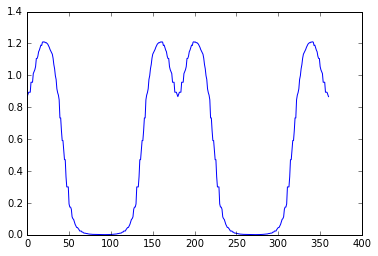

In [144]:
%matplotlib inline

plt.plot(np.rad2deg(np.concatenate((phi_vector,phi_vector_2q,phi_vector_3q,phi_vector_4q))),np.concatenate((B_profile,B_profile_2q,B_profile_3q,B_profile_4q)))